### This file is for generating actionable insights from the model outputs
- for the sake of creating an MVP im going to use the data directly from dad's store
- For the real product I will pull the data from the models and use those

In [96]:
import polars as pl
def adjust_brands(data_frame):
    """
    Renames BMW columns.
    
    This function updates 'supplier_name' to 'bmw' for all entries that contain 'bmw',
    case-insensitively.
    """
    # Ensuring case-insensitive comparison and updating 'supplier_name'
    data_frame = data_frame.with_columns(
        pl.when(
            pl.col('supplier_name').str.contains_any(["bmw"])
        ).then(pl.lit('bmw'))  # Set to 'bmw' if the condition is true
        .otherwise(pl.col('supplier_name'))  # Keep the original if the condition is false
        .alias('supplier_name')  # Ensure the column name remains 'supplier_name'
    )
    return data_frame

df_test = pl.DataFrame({
    'supplier_name': ['BMW AG', 'bmw motors', 'Mercedes-Benz', 'Audi', 'bmw', 'island bmw']
})

# Apply the function
df_test = adjust_brands(df_test)
print(df_test.columns)
print(df_test)


['supplier_name']
shape: (6, 1)
┌───────────────┐
│ supplier_name │
│ ---           │
│ str           │
╞═══════════════╡
│ BMW AG        │
│ bmw           │
│ Mercedes-Benz │
│ Audi          │
│ bmw           │
│ bmw           │
└───────────────┘


In [70]:


def convert_to_float(df, column_name):
    # First, remove spaces that might be used as thousand separators
    df = df.with_columns(
        pl.col(column_name)
        .str.replace(",", "")
        .alias("no_comma")
    )
    print("After removing spaces:", df.get_column("no_comma").to_list())

    # Then remove commas which might be used as thousand separators
    df = df.with_columns(
        pl.col("no_comma")
        .str.replace(",", "")
        .cast(pl.Float64, strict=False)
        .alias(column_name)
    )
    print("After removing commas and casting:", df.get_column(column_name).to_list())

    # Remove the intermediate 'no_spaces' column if no longer needed
    df = df.drop("no_comma")

    return df

# Example of using the function
df = pl.DataFrame({
    "price": ["10,000.00", "20 000,50", "30.000,00", "44,993750.00"]
})

df = convert_to_float(df, "price")
print(df)

After removing spaces: ['10000.00', '20 00050', '30.00000', '44993750.00']
After removing commas and casting: [10000.0, None, 30.0, 44993750.0]
shape: (4, 1)
┌────────────┐
│ price      │
│ ---        │
│ f64        │
╞════════════╡
│ 10000.0    │
│ null       │
│ 30.0       │
│ 4.499375e7 │
└────────────┘


In [393]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar

def create_long_form_dataframe(df: pl.DataFrame) -> pl.DataFrame:
    """
    Convert a wide-format DataFrame containing monthly sales data into a long-format DataFrame.
    """
    current_year = datetime.now().year
    last_year = current_year - 1
    current_month_index = datetime.now().month

    this_year_sales_columns = [f'sales_{calendar.month_abbr[i].lower()}' for i in range(1, current_month_index + 1)]
    last_year_sales_columns = [f'sales_last_{calendar.month_abbr[i].lower()}' for i in range(1, 13)]

    # Helper function to unpivot and clean data
    def unpivot_and_clean(data, columns, year):
        return (data.unpivot(
                    index=["part_number"], 
                    on=columns, 
                    variable_name='month', 
                    value_name='quantity_sold'
                )
                .with_columns([
                    pl.lit(year).alias('year'),
                    pl.col("month").str.replace("sales_", "").str.replace("last_", "").str.replace("_", "")
                ])
        )

    df_this_year = unpivot_and_clean(df, this_year_sales_columns, current_year)
    df_last_year = unpivot_and_clean(df, last_year_sales_columns, last_year)

    return pl.concat([df_this_year, df_last_year])

def calculate_rolling_sales(df_long):
    """
    Calculate rolling sales sums for 3-month and 12-month periods.

    Args:
        df_long (pl.DataFrame): DataFrame with 'part_number' and 'quantity_sold'. Each row 
                                corresponds to sales data for a part number in a specific month.

    Returns:
        pl.DataFrame: The DataFrame is returned with two new columns:
                      - 'rolling_3m_sales': 3-month rolling sum of 'quantity_sold'.
                      - 'rolling_12m_sales': 12-month rolling sum of 'quantity_sold'.

    Notes:
        The function assumes data is sorted and grouped by 'part_number'.
        Rolling sums reset at the change of 'part_number'.
    """

    df_long = df_long.with_columns([
        pl.col("quantity_sold").rolling_sum(window_size=3, min_periods=1).over("part_number").alias("rolling_3m_sales"),
        pl.col("quantity_sold").rolling_sum(window_size=12, min_periods=1).over("part_number").alias("rolling_12m_sales")
    ])
    return df_long


df_wide = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data_cleaned.csv')
df = create_long_form_dataframe(df_wide)
df

part_number,month,quantity_sold,year
str,str,i64,i32
"""286065606""","""jan""",0,2024
"""5262804-01""","""jan""",0,2024
"""56410711a""","""jan""",0,2024
"""0316-0349""","""jan""",0,2024
"""555-06474""","""jan""",0,2024
…,…,…,…
"""34117651954""","""dec""",0,2023
"""23008569917""","""dec""",0,2023
"""t3600112""","""dec""",0,2023


In [396]:
import polars as pl
import numpy as np

def create_seasonal_df(df):
    """
    Create a datetime column from year and month, and add cyclical features based on the datetime.

    Args:
        df (pl.DataFrame): DataFrame containing year and month columns.
        year_col (str): Column name with the year.
        month_col (str): Column name with the month name.

    Returns:
        pl.DataFrame: Enhanced DataFrame with datetime and cyclical features.
    """
    # Map month names to numbers (if needed)
    month_to_number = {month.lower(): i for i, month in enumerate(calendar.month_abbr) if month}

    # Create a datetime column assuming the first day of each month
    month_number_expr = pl.when(pl.col("month").str.to_lowercase() == "jan").then(1)
    for month, num in month_to_number.items():
        month_number_expr = month_number_expr.when(pl.col("month").str.to_lowercase() == month).then(num)

    # Apply the case expression
    df = df.with_columns(month_number_expr.alias("month_number"))

    month_numbers = df.get_column("month_number").to_numpy()  # Convert to numpy array for calculations
    month_sin = np.sin(2 * np.pi * month_numbers / 12)
    month_cos = np.cos(2 * np.pi * month_numbers / 12)

    # Add calculated columns back to DataFrame
    df = df.with_columns([
        pl.Series("month_sin", month_sin),
        pl.Series("month_cos", month_cos)
    ])
    
    return df

def create_seasonal_component(df, window_size=12):
    """
    Enhance a DataFrame with a rolling average and combine it with cyclical features to create a seasonal component.

    Args:
        df (pl.DataFrame): DataFrame with columns for part number, date, quantity sold, and cyclical features.
        window_size (int): Size of the rolling window for calculating the moving average.

    Returns:
        pl.DataFrame: DataFrame with added rolling average and seasonal adjustment features.
    """
    # Calculate the rolling mean for the quantity sold
    df = df.with_columns(
        pl.col("quantity_sold").rolling_mean(window_size=window_size, min_periods=1).alias("rolling_avg")
    )

    # Calculate deviation from the rolling average
    df = df.with_columns(
        (pl.col("quantity_sold") - pl.col("rolling_avg")).alias("deviation")
    )

    # Combine cyclical features with deviations to create a seasonal score
    df = df.with_columns(
        (pl.col("deviation") * pl.col("month_sin") + pl.col("deviation") * pl.col("month_cos")).alias("seasonal_score")
    )

    # You could also normalize this score by the number of observations (i.e., months) for each part number
    df = df.group_by("part_number").agg([
        pl.mean("seasonal_score").alias("normalized_seasonal_score")
    ])

    return df


# Assuming df is already defined
df_processed = create_seasonal_df(df)
seasonal_df = create_seasonal_component(df_processed)

df_wide = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data_cleaned.csv')
final_df = df_wide.join(seasonal_df, on=pl.col('part_number'), how='left')
final_df

part_number,sales_last_jan,sales_last_feb,sales_last_mar,sales_last_apr,sales_last_may,sales_last_jun,sales_last_jul,sales_last_aug,sales_last_sep,sales_last_oct,sales_last_nov,sales_last_dec,sales_jan,sales_feb,sales_mar,sales_apr,sales_may,sales_jun,sales_jul,sales_aug,sales_sep,sales_oct,sales_nov,sales_dec,quantity,quantity_ordered_ytd,special_orders_ytd,description,margin,price,supplier_name,months_no_sale,negative_on_hand,normalized_seasonal_score
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,str,i64,i64,f64
"""286065606""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,"""mw montana waxed jkt-l""",348.74,464.99,"""polaris acceptance""",18,0,0.079808
"""5262804-01""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"""console-inner,pat3202m""",49.7,141.99,"""polaris acceptance""",32,0,0.021185
"""56410711a""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"""guard, flap""",67.8,224.99,"""ducati""",19,0,0.019579
"""0316-0349""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,"""110/80r19 59v road 5 trail fro""",235.05,411.99,"""parts canada/power twins""",18,0,0.067825
"""555-06474""",0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""wfx3 wp black l""",36.02,119.99,"""motovan""",17,0,-0.033052
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""34117651954""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"""set of mounting parts, left""",14.75,43.99,"""bmw group canada""",19,0,0.013158
"""23008569917""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,"""chain pinion""",53.79,110.99,"""bmw group canada""",19,0,0.004386
"""t3600112""",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""seal ,countershaft 40 62 6""",6.27,16.99,"""triumph motorcycles""",18,0,-0.061519


In [402]:
print('Calculating current month sales for 30 days supply...')
df = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data_cleaned.csv')
current_month = datetime.now().month - 1
month_abbr = calendar.month_abbr[current_month].lower()
this_month_sales_column = f'sales_{month_abbr}'

this_month_sales_sum = df.select([
        pl.col(this_month_sales_column).sum().alias('total_sales_current_month')
    ])
print(this_month_sales_sum)

Calculating current month sales for 30 days supply...
shape: (1, 1)
┌───────────────────────────┐
│ total_sales_current_month │
│ ---                       │
│ i64                       │
╞═══════════════════════════╡
│ 2411                      │
└───────────────────────────┘


In [390]:
df = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data_cleaned.csv')

def fun_funct(df):

    current_month =  datetime.now().month
    this_year_sales_columns = [f'sales_{calendar.month_abbr[i].lower()}' for i in range(1, current_month + 1)]

    df = df.with_columns(
            (pl.col('price') - pl.col('margin')).round(2).alias('cost_per_unit')
        )
    df.with_columns(
        (pl.col('cost_per_unit') * pl.col('quantity')).round(2).alias('total_cost')
    )
    total_sales_ytd = pl.sum_horizontal(this_year_sales_columns).alias('total_sales_ytd')

    df = df.with_columns(total_sales_ytd)

    df = df.with_columns([
        (pl.col('total_sales_ytd') * pl.col('price')).round(2).alias('sales_revenue'),
        (pl.col('total_sales_ytd') * pl.col('cost_per_unit')).round(2).alias('cogs')
    ])

    # Calculate 'gross_profit'
    df = df.with_columns([
        (pl.col('sales_revenue') - pl.col('cogs')).round(2).alias('gross_profit')
    ])

    # Calculate 'roi'
    df = df.with_columns([
        pl.when(pl.col('cogs') > 0)
        .then((pl.col('gross_profit') / pl.col('cogs')) * 100)
        .otherwise(0.00)
        .round(2)
        .alias('roi')
    ])

    return df


df_n = fun_funct(df)
df_n

part_number,sales_last_jan,sales_last_feb,sales_last_mar,sales_last_apr,sales_last_may,sales_last_jun,sales_last_jul,sales_last_aug,sales_last_sep,sales_last_oct,sales_last_nov,sales_last_dec,sales_jan,sales_feb,sales_mar,sales_apr,sales_may,sales_jun,sales_jul,sales_aug,sales_sep,sales_oct,sales_nov,sales_dec,quantity,quantity_ordered_ytd,special_orders_ytd,description,margin,price,supplier_name,months_no_sale,negative_on_hand,cost_per_unit,total_sales_ytd,sales_revenue,cogs,gross_profit,roi
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,str,i64,i64,f64,i64,f64,f64,f64,f64
"""286065606""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,"""mw montana waxed jkt-l""",348.74,464.99,"""polaris acceptance""",18,0,116.25,1,464.99,116.25,348.74,299.99
"""5262804-01""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"""console-inner,pat3202m""",49.7,141.99,"""polaris acceptance""",32,0,92.29,0,0.0,0.0,0.0,0.0
"""56410711a""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"""guard, flap""",67.8,224.99,"""ducati""",19,0,157.19,0,0.0,0.0,0.0,0.0
"""0316-0349""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,"""110/80r19 59v road 5 trail fro""",235.05,411.99,"""parts canada/power twins""",18,0,176.94,1,411.99,176.94,235.05,132.84
"""555-06474""",0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""wfx3 wp black l""",36.02,119.99,"""motovan""",17,0,83.97,0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""34117651954""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"""set of mounting parts, left""",14.75,43.99,"""bmw group canada""",19,0,29.24,0,0.0,0.0,0.0,0.0
"""23008569917""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,"""chain pinion""",53.79,110.99,"""bmw group canada""",19,0,57.2,0,0.0,0.0,0.0,0.0
"""t3600112""",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""seal ,countershaft 40 62 6""",6.27,16.99,"""triumph motorcycles""",18,0,10.72,0,0.0,0.0,0.0,0.0


In [336]:
number_of_dealerships = 35000 + 4000 + 8000
number_of_wholesalers = 157_000 + 11_000 + 30_000
number_of_dealerships_global = 1_913_948
number_of_wholesalers_global = 10_000_000
value_of_inventory = 520_000
value_obsolete_inventory = value_of_inventory * 0.15
percentage_obsolescence_cleared = 0.667
commission_rate = 0.1
dealer_subscription = 499.99 * 12  # Annual subscription
wholesaler_subscription = 29.99 * 12

# Revenue calculations
revenue_from_obsolescence_per_dealership_global = value_obsolete_inventory * percentage_obsolescence_cleared * commission_rate
total_revenue_obsolescence_global = revenue_from_obsolescence_per_dealership_global * number_of_dealerships_global
total_subscription_revenue_global = (dealer_subscription * number_of_dealerships_global) + (wholesaler_subscription * number_of_wholesalers_global)

revenue_from_obsolescence_per_dealership = value_obsolete_inventory * percentage_obsolescence_cleared * commission_rate
total_revenue_obsolescence = revenue_from_obsolescence_per_dealership * number_of_dealerships
total_subscription_revenue = (dealer_subscription * number_of_dealerships) + (wholesaler_subscription * number_of_wholesalers)

# Market sizes
TAM = total_revenue_obsolescence_global + total_subscription_revenue_global
SAM = total_revenue_obsolescence + total_subscription_revenue
SOM = SAM * 0.15  # Assuming 15% market penetration

# Print formatted results
print(f'Total Dealerships in North America: {number_of_dealerships} ')
print(f"Average Revenue from Obsolescence per Dealership: ${revenue_from_obsolescence_per_dealership:,.2f}")
print(f"Total Revenue from Obsolescence: ${total_revenue_obsolescence:,.2f}")
print(f"Total Subscription Revenue: ${total_subscription_revenue:,.2f}")
print('-----------------------------------------------------')
print(f"Total Addressable Market (TAM): ${TAM:,.2f}")
print(f"Serviceable Addressable Market (SAM): ${SAM:,.2f}")
print(f"Serviceable Obtainable Market (SOM): ${SOM:,.2f}")

Total Dealerships in North America: 47000 
Average Revenue from Obsolescence per Dealership: $6,936.80
Total Revenue from Obsolescence: $326,029,600.00
Total Subscription Revenue: $353,250,600.00
-----------------------------------------------------
Total Addressable Market (TAM): $28,358,932,812.64
Serviceable Addressable Market (SAM): $679,280,200.00
Serviceable Obtainable Market (SOM): $101,892,030.00


shape: (337_459, 8)
┌─────────────┬───────┬───────────────┬──────┬───────────┬──────────────┬────────────┬────────────┐
│ part_number ┆ month ┆ quantity_sold ┆ year ┆ month_str ┆ month_number ┆ year_month ┆ 6_month_MA │
│ ---         ┆ ---   ┆ ---           ┆ ---  ┆ ---       ┆ ---          ┆ ---        ┆ ---        │
│ str         ┆ str   ┆ i64           ┆ i32  ┆ str       ┆ i64          ┆ i64        ┆ f64        │
╞═════════════╪═══════╪═══════════════╪══════╪═══════════╪══════════════╪════════════╪════════════╡
│ 286065606   ┆ jan   ┆ 0             ┆ 2023 ┆ jan       ┆ 1            ┆ 202301     ┆ 0.0        │
│ 5262804-01  ┆ jan   ┆ 0             ┆ 2023 ┆ jan       ┆ 1            ┆ 202301     ┆ 0.0        │
│ 56410711a   ┆ jan   ┆ 0             ┆ 2023 ┆ jan       ┆ 1            ┆ 202301     ┆ 0.0        │
│ 0316-0349   ┆ jan   ┆ 0             ┆ 2023 ┆ jan       ┆ 1            ┆ 202301     ┆ 0.0        │
│ 555-06474   ┆ jan   ┆ 0             ┆ 2023 ┆ jan       ┆ 1            ┆ 202301

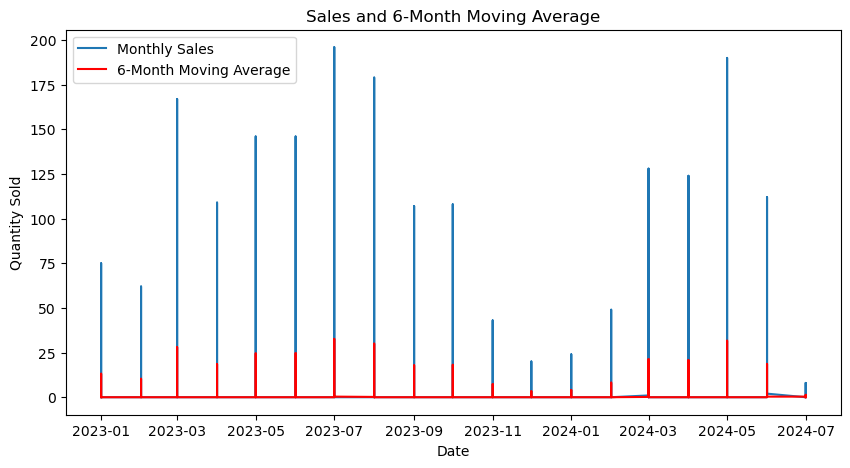

In [171]:
import pandas as pd
month_to_number = {month.lower(): i for i, month in enumerate(calendar.month_abbr[1:], start=1)}

# Create a helper DataFrame from the dictionary
month_mapping_df = pl.DataFrame({
    "month_str": list(month_to_number.keys()),
    "month_number": list(month_to_number.values())
})

# Join the DataFrame with the month mapping
df = df.join(month_mapping_df, left_on=pl.col("month").str.to_lowercase(), right_on="month_str")

# Create a combined year_month column that is sortable
df = df.with_columns(
    (pl.col("year") * 100 + pl.col("month_number")).alias("year_month")
).sort("year_month")

# Calculate the 6-month moving average for 'quantity_sold'
df = df.with_columns(
    pl.col("quantity_sold").rolling_mean(window_size=6, min_periods=1).alias("6_month_MA")
)

# Optionally, display the DataFrame to check results
print(df)

# Convert to Pandas for plotting (optional)
pdf = df.to_pandas()

# Convert 'year_month' into a proper date format for plotting
pdf['Date'] = pd.to_datetime(pdf['year_month'].astype(str), format='%Y%m')

plt.figure(figsize=(10, 5))
plt.plot(pdf['Date'], pdf['quantity_sold'], label='Monthly Sales')
plt.plot(pdf['Date'], pdf['6_month_MA'], label='6-Month Moving Average', color='red')
plt.title('Sales and 6-Month Moving Average')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

In [104]:
import polars as pl
from datetime import datetime
import calendar

df = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data_cleaned.csv')

def create_long_form_dataframe(df: pl.DataFrame) -> pl.DataFrame:
    """
    Convert a wide-format DataFrame containing monthly sales data into a long-format DataFrame,
    and compute 3-month and 12-month rolling sales.

    Args:
        df (pl.DataFrame): DataFrame containing sales data for the current and previous years with columns
                           named 'sales_<month_abbr>' and 'sales_last_<month_abbr>'.

    Returns:
        pl.DataFrame: A long-format DataFrame with 'part_number', 'month', 'year', 'quantity_sold',
                      and rolling sales columns for 3-month and 12-month periods.
    """
    # Define current year and last year for labeling purposes
    current_year = datetime.now().year
    last_year = current_year - 1
    current_month_index = datetime.now().month

    # Define sales columns for this year and last year
    this_year_sales_columns = [f'sales_{calendar.month_abbr[i].lower()}' for i in range(1, current_month_index + 1)]
    last_year_sales_columns = [f'sales_last_{calendar.month_abbr[i].lower()}' for i in range(1, 13)]

    df_this_year = df.unpivot(
        index=["part_number"], 
        on=this_year_sales_columns, 
        variable_name='month', 
        value_name='quantity_sold'
    )
    df_this_year = df_this_year.with_columns(pl.lit(current_year).alias('year'))

    # Melt last year's sales data
    df_last_year = df.unpivot(
        index=["part_number"], 
        on=last_year_sales_columns, 
        variable_name='month', 
        value_name='quantity_sold'
    )
    df_last_year = df_last_year.with_columns(pl.lit(last_year).alias('year'))

    # Clean up month names and adjust for rolling calculations
    df_long = pl.concat([
        df_this_year,
        df_last_year
    ]).with_columns(
        pl.col("month").str.replace("sales_", "").str.replace("last_", "").str.replace("_", "")
    )

    # Compute rolling sums for 3-month and 12-month periods
    df_long = df_long.with_columns([
        pl.col("quantity_sold").rolling_sum(window_size=3, min_periods=1).over("part_number").alias("rolling_3m_sales"),
        pl.col("quantity_sold").rolling_sum(window_size=12, min_periods=1).over("part_number").alias("rolling_12m_sales")
    ])

    return df_long

# Example usage might follow here after ensuring `df` has all required columns and correct data types.
df = create_long_form_dataframe(df)
df


part_number,month,quantity_sold,year,rolling_3m_sales,rolling_12m_sales
str,str,i64,i32,i64,i64
"""286065606""","""jan""",0,2024,0,0
"""5262804-01""","""jan""",0,2024,0,0
"""56410711a""","""jan""",0,2024,0,0
"""0316-0349""","""jan""",0,2024,0,0
"""555-06474""","""jan""",0,2024,0,0
…,…,…,…,…,…
"""34117651954""","""dec""",0,2023,0,0
"""23008569917""","""dec""",0,2023,0,0
"""t3600112""","""dec""",0,2023,0,1


In [86]:
import pandas as pd
df = pd.read_feather("/Users/skylerwilson/Desktop/PartsWise/Data/Output/parts_data.feather")

# "what brand has the least total obsolete parts out of my top 5 brands with the highest gross profit?"


mask = df['inventory_category'] == 'obsolete'
qdf = df[mask].groupby('supplier_name')['quantity'].sum().sort_values()

# Calculating total gross profit per supplier
gpdf = df.groupby('supplier_name')['gross_profit'].sum().sort_values(ascending=False)

# Merging the two dataframes
fdf = pd.merge(gpdf, qdf, on='supplier_name', how='left').reset_index()

# Filter for top 5 brands by gross profit
top_5_gross_profit = fdf.nlargest(5, 'gross_profit')

# Sorting the top 5 by quantity of obsolete parts
result = top_5_gross_profit.sort_values(by='quantity', ascending=True)
result

,supplier_name,gross_profit,quantity
4,kimpex,25164.16,272.0
1,parts canada/power twins,57019.86,595.0
3,triumph motorcycles,27687.13,1418.0
2,polaris acceptance,39340.29,2808.0
0,bmw group canada,89368.96,10317.0


In [11]:
df = pd.read_feather("/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/output_data/parts_data.feather")
mask = df['inventory_category'] == 'obsolete'
gm = df[~mask][['part_number', 'description', 'supplier_name', 'roi']]

# Group by supplier_name and calculate the average margin_percentage
grouped_gm = gm.groupby('supplier_name')['roi'].mean().reset_index()

# Sort by margin_percentage in descending order
grouped_gm_sorted = grouped_gm.sort_values(by='roi', ascending=False)

# Display the result
print(grouped_gm_sorted)

                   supplier_name         roi
4               bumper to bumper  670.730000
8        earthtrack supply group  419.920000
7                         ducati  318.193846
17                        lordco  198.443333
19                          moto  176.430000
18                       mavrick  176.190000
22      parts canada/power twins  149.251872
16                        kimpex   75.347229
20                       motovan   49.099219
11                     full bore    7.357500
0    action motorcycles / barnes    0.000000
28                       triumph   -7.776788
12  fundy textile and design ltd  -15.825000
25                     schuberth  -19.770000
23            polaris acceptance  -20.268584
27               thibault canada  -22.756410
3               bmw group canada  -23.011650
32              zero motorcycles  -25.000000
29           triumph motorcycles  -32.431729
26                  shell canada  -45.715000
2                bell sports inc  -48.235000
13        

In [25]:
df = pd.read_feather("/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/output_data/parts_data.feather")


,part_number,description,supplier_name,quantity,price,margin,months_no_sale,quantity_ordered_ytd,special_orders_ytd,negative_on_hand,...,one_month_turnover,sell_through_rate,days_of_inventory_outstanding,order_to_sales_ratio,seasonal_component,demand,inventory_category,safety_stock,reorder_point,obsolescence_risk
3832,34527708523,o-ring,bmw group canada,339,4.99,2.27,1,0,0,0,...,0.0,1.769912,30,0.0,13.0,1.000000,essential,0,0,0.076996
8543,84010702b,"adjuster, closing rocker arm",ducati,8,24.99,24.98,3,0,0,0,...,0.0,12.500000,3650,0.0,0.0,0.999831,essential,0,0,0.253191
5143,501-170a,drain plug washer-crush,motovan,548,1.99,1.76,4,0,0,0,...,0.0,1.094891,120,0.0,19.0,0.999662,essential,0,0,0.281117
8544,84010712b,"adjuster, closing rocker arm",ducati,9,24.99,24.98,3,0,0,0,...,0.0,11.111111,3650,0.0,0.0,0.999493,essential,0,0,0.257749
8493,84010102a,"adjuster, opening rocker arm",ducati,5,11.99,11.98,3,0,0,0,...,0.0,20.000000,1825,0.0,1.0,0.999324,essential,0,0,0.703817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4780,46631238881,mirror base left,bmw group canada,1,76.99,27.27,18,0,0,0,...,0.0,0.000000,540,0.0,0.0,0.000000,obsolete,0,0,1.000000
4781,46631240627,cap,bmw group canada,3,8.99,3.93,18,0,0,0,...,0.0,0.000000,540,0.0,0.0,0.000000,obsolete,0,0,1.000000
4782,46631240653,clamping plate left,bmw group canada,1,6.99,2.98,18,0,0,0,...,0.0,0.000000,540,0.0,0.0,0.000000,obsolete,0,0,1.000000
4783,46631240654,clamping plate right,bmw group canada,1,8.99,3.26,18,0,0,0,...,0.0,0.000000,540,0.0,0.0,0.000000,obsolete,0,0,1.000000


In [24]:
obs_cost = df[mask].groupby('supplier_name')['total_cost'].sum()

gp = df.groupby('supplier_name')['gross_profit'].sum()

gm = df.groupby('supplier_name')['margin_percentage'].mean().reset_index()

fdf = pd.merge(obs_cost, gp, on='supplier_name', how='left').reset_index()

df = pd.merge(fdf, gm, on='supplier_name', how='left').reset_index()

df['ratio'] = df['gross_profit']/fdf['total_cost']
df.sort_values(by='ratio', ascending=False)

,index,supplier_name,total_cost,gross_profit,margin_percentage,ratio
41,41,shell canada,341.88,5556.51,53.385000,16.252808
15,15,east penn canada,54.69,166.30,51.355000,3.040775
35,35,parts canada/power twins,44941.30,82860.60,44.810040,1.843752
5,5,beeline moto,122.40,165.11,57.932500,1.348938
25,25,kimpex,19278.82,24711.89,42.150165,1.281815
28,28,mavrick,549.33,598.86,48.600000,1.090164
18,18,gamma sales inc.,317.85,207.98,36.573000,0.654334
39,39,schuberth,11101.11,6733.50,37.423000,0.606561
45,45,triumph,74055.35,37211.07,45.163483,0.502476
17,17,fundy textile and design ltd,650.89,291.63,44.803243,0.448048


In [89]:
og_df = pd.read_feather("/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data.feather")
og_df.columns

Index(['part_number', 'description', 'supplier_name', 'quantity', 'price',
       'margin', 'months_no_sale', 'quantity_ordered_ytd',
       'special_orders_ytd', 'sales_last_jan', 'sales_last_feb',
       'sales_last_mar', 'sales_last_apr', 'sales_last_may', 'sales_last_jun',
       'sales_last_jul', 'sales_last_aug', 'sales_last_sep', 'sales_last_oct',
       'sales_last_nov', 'sales_last_dec', 'sales_jan', 'sales_feb',
       'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 'sales_jul',
       'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 'sales_dec',
       'negative_on_hand', 'rolling_12_month_sales', 'rolling_3_month_sales',
       'cost_per_unit', 'total_cost', 'sales_revenue', 'cogs',
       'margin_percentage', 'gross_profit', 'roi', 'annual_days_supply',
       'three_month_days_supply', 'one_month_days_supply', 'annual_turnover',
       'three_month_turnover', 'one_month_turnover', 'sales_to_stock_ratio',
       'order_to_sales_ratio', 'seasonal_component', 'demand'

In [ ]:
import logging
import pandas as pd
import numpy as np
import regex as re
from sqlalchemy import text
import plotly.express as px
import plotly.graph_objects as go
from llama_index.core import PromptTemplate

def generate_plotly_visual(df, chart_type, title, x_axis_label, y_axis_label, hover_labels):
    # Filtering existing hover data columns
    hover_data = [col for col in hover_labels if col in df.columns]

    # Preparing customdata correctly, ensuring it matches the data length
    custom_data_adjusted = df[hover_data].values if hover_data else None

    # Building the hover template
    hover_template = "<br>".join([f"{col}: %{{customdata[{i}]}}" for i, col in enumerate(hover_data)])

    if chart_type == "line":
        fig = px.line(df, x=df.columns[0], y=df.columns[1:], title=title)
        if custom_data_adjusted is not None:
            fig.update_traces(customdata=custom_data_adjusted, hovertemplate=hover_template + "<extra></extra>")

    elif chart_type == "bar":
        fig = go.Figure()
        for col in df.columns[1:]:
            fig.add_trace(go.Bar(
                x=df[df.columns[0]], 
                y=df[col],
                name=col,
                customdata=custom_data_adjusted,
                hovertemplate=hover_template + "<extra></extra>"
            ))
        fig.update_layout(title=title, xaxis_title=x_axis_label, yaxis_title=y_axis_label, barmode='group')

    elif chart_type == "scatter":
        fig = px.scatter(df, x=df.columns[0], y=df.columns[1:], title=title)
        if custom_data_adjusted is not None:
            fig.update_traces(customdata=custom_data_adjusted, hovertemplate=hover_template + "<extra></extra>")

    elif chart_type == "pie":
        fig = px.pie(df, names=df.columns[0], values=df.columns[1], title=title)
        if custom_data_adjusted is not None:
            # Ensure each column of custom_data_adjusted matches the length of the main data
            custom_data_adjusted = np.array([custom_data_adjusted[:, i] if i < custom_data_adjusted.shape[1] else ['N/A']*len(df) for i in range(len(hover_data))]).T
            fig.update_traces(customdata=custom_data_adjusted, hovertemplate=hover_template + "<extra></extra>")

    else:
        fig = px.scatter(df, x=df.columns[0], y=df.columns[1:], title=title)
        if custom_data_adjusted is not None:
            fig.update_traces(customdata=custom_data_adjusted, hovertemplate=hover_template + "<extra></extra>")

    # Apply common layout updates
    fig.update_layout(
        title={'text': title, 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
        xaxis_title=x_axis_label,
        yaxis_title=y_axis_label,
        hovermode="closest",
        plot_bgcolor='white',  
        paper_bgcolor='white',  
        font=dict(family="Arial, sans-serif", size=12, color="Gray"),
        xaxis=dict(showline=True, linecolor='Gray', linewidth=1, tickformat=',', title_standoff=10, tickfont=dict(size=14), titlefont=dict(size=16)),
        yaxis=dict(showline=True, linecolor='Gray', linewidth=1, tickformat=',', title_standoff=10, tickfont=dict(size=14), titlefont=dict(size=16)),
        legend=dict(x=0.5, y=-0.175, xanchor='center', yanchor='top', orientation='h', bgcolor='rgba(255,255,255,0.8)', bordercolor='Gray', borderwidth=1, font=dict(size=16)),
        margin=dict(l=50, r=50, t=50, b=0)
    )

    return fig.show()

def extract_chart_details(query_engine, user_input):
    text_qa_template_str = (
        "Given the query: '{query_str}', extract the following details, adding hover data to enhance the utility of the charts:\n"
        "1. Chart type (e.g., bar, line, pie, etc.)\n"
        "2. Title for the chart\n"
        "3. X-axis label\n"
        "4. Y-axis label\n"
        "5. Additional columns for hover data\n"
        "\n"
        "Provide the details in the following format:\n"
        "Chart type: <type>\n"
        "Title: <title>\n"
        "X-axis label: <label>\n"
        "Y-axis label: <label>\n"
        "Hover data: <column1>, <column2>, ...\n"
    )
    text_qa_template = PromptTemplate(text_qa_template_str)
    
    prompt = text_qa_template.format(query_str=user_input)
    response = query_engine.query(prompt)
    logging.info(f"LLM Response: {response.response.strip()}")
    response_text = response.response.strip()
    lines = response_text.split('\n')
    
    chart_type = "bar"  # Default value
    title = "Generated Chart"
    x_axis_label = "X Axis"
    y_axis_label = "Y Axis"
    hover_data = []

    for line in lines:
        if "Chart type:" in line:
            chart_type = line.split(":", 1)[1].strip().lower()
        elif "Title:" in line:
            title = line.split(":", 1)[1].strip()
        elif "X-axis label:" in line:
            x_axis_label = line.split(":", 1)[1].strip()
        elif "Y-axis label:" in line:
            y_axis_label = line.split(":", 1)[1].strip()
        elif "Hover data:" in line:
            hover_data = [col.strip().lower().replace(' ', '_') for col in line.split(":", 1)[1].strip().split(',')]
    return {
        "chart_type": chart_type, 
        "title": title, 
        "x_axis_label": x_axis_label, 
        "y_axis_label": y_axis_label, 
        "hover_labels": hover_data
    }


def output_sql_query_to_graph(result_data, columns, chart_type, title, x_axis_label, y_axis_label, hover_labels):
    result_df = pd.DataFrame(result_data, columns=columns)
    hovertext = {col: True for col in hover_labels} if hover_labels else None
    fig = generate_plotly_visual(result_df, chart_type, title, x_axis_label, y_axis_label, hovertext)
    fig.show()

def handle_visual_query(query_engine, user_input):
    sql_query = query_engine.query(user_input, return_sql=True)
    with query_engine.engine.connect() as connection:
        result = connection.execute(text(sql_query))
        result_data = result.fetchall()
        columns = result.keys()
    chart_type, title, x_axis_label, y_axis_label, hover_labels = extract_chart_details(query_engine, user_input)
    return output_sql_query_to_graph(result_data, columns, chart_type, title, x_axis_label, y_axis_label, hover_labels)


class QueryProcessor:
    def __init__(self):
        self.sql_keywords = [
            'SELECT', 'DROP', 'INSERT', 'DELETE', 'UPDATE', 'CREATE', 
            'ALTER', 'EXEC', 'UNION', 'DECLARE'
        ]

    def remove_sql_keywords(self, text):
        pattern = r'\b(' + '|'.join(self.sql_keywords) + r')\b'
        return re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    def normalize_whitespace_and_characters(self, text):
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s%]', '', text)
        return text

    def preprocess_query(self, user_input):
        user_input = user_input.lower().strip()
        user_input = re.sub(r'(\d+)%', lambda match: str(float(match.group(1)) / 100), user_input)
        user_input = self.normalize_whitespace_and_characters(user_input)
        user_input = self.remove_sql_keywords(user_input)
        return user_input
    


    import logging
import pandas as pd
from functools import lru_cache
from sqlalchemy import create_engine, text
import os
import openai
from llama_index.core import SQLDatabase, VectorStoreIndex
from llama_index.core.objects import (
    SQLTableNodeMapping,
    ObjectIndex,
    SQLTableSchema,
)
from llama_index.core.indices.struct_store import SQLTableRetrieverQueryEngine
from llama_index.llms.openai import OpenAI

class NLQueryEngine:
    def __init__(self, engine):
        self.engine = engine
        self.sql_database, self.table_schema_objs, self.obj_index = self._initialize_table_objects()
        self.context_str_combined = self._create_context_str()
        openai.api_key = os.environ["OPENAI_API_KEY"]
        self.query_engine = self._create_query_engine()

    def _initialize_table_objects(self):
        sql_database = SQLDatabase(self.engine, sample_rows_in_table_info=2, include_tables=['sales', 'parts'])
        table_contexts = {
            'sales': "Provides time-based sales count data for individual parts. Use for part-specific sales queries. No price column",
            'parts': "Provides detailed inventory data for individual parts. Use part-specific queries. Combine with 'sales' tables for temporal financial performance"
        }

        table_schema_objs = [SQLTableSchema(table_name=name, context_str=context) for name, context in table_contexts.items()]
        table_node_mapping = SQLTableNodeMapping(sql_database)

        obj_index = ObjectIndex.from_objects(
            table_schema_objs,
            table_node_mapping,
            VectorStoreIndex,
        )
        return sql_database, table_schema_objs, obj_index
    
    @lru_cache()
    def _create_context_str(self):
        context_str = (
            "Inventory categories: essential, non-essential, nearing obsolescence, obsolete. "
            "Ensure detailed, relevant responses and ALWAYS include numerical figures wherever possible'. "
            "Access 'supplier_name' flexibly e.g., ('%bmw%'). "
            "Use JOINs prefaced with table names for combining multiple tables. "
            "Calculate COGS as the sum of costs directly associated with goods sold. "
            "Calculate Gross Margin Percentage/Gross Margin as (Quantity Sold * Price - COGS) / Quantity Sold * Price * 100. "
            "Order months chronologically (e.g., january, february, ..., december) in query results."
        )
        table_context_str = self._get_table_context_str()
        return context_str + "\n\n" + table_context_str
    
    @lru_cache()
    def _get_table_context_str(self):
        context_strs = []
        for table_schema_obj in self.table_schema_objs:
            table_info = self.sql_database.get_single_table_info(table_schema_obj.table_name)
            if table_schema_obj.context_str:
                table_info += f" The table description is: {table_schema_obj.context_str}"
            context_strs.append(table_info)
        return "\n\n".join(context_strs)

    def _create_query_engine(self):
        return SQLTableRetrieverQueryEngine(
            sql_database=self.sql_database,
            table_retriever=self.obj_index.as_retriever(similarity_top_k=1),
            synthesize_response=True,
            llm=OpenAI(temperature=0.1, model="gpt-3.5-turbo-0125"),
            context_str_prefix=self.context_str_combined
        )
    
    def query(self, user_input, return_sql=False):
        response = self.query_engine.query(user_input)
        if return_sql:
            return response.metadata.get('sql_query', '')
        return response
    
    @staticmethod
    def parse_intent(user_input):
        if any(keyword in user_input.lower() for keyword in ["visual", "chart", "graph", "plot", "bar", "pie", "line"]):
            return "visual"
        return "text"

    def generate_visual(self, result_data, columns, chart_details):
        """ Generate a visual representation based on the query results """
        df = pd.DataFrame(result_data, columns=columns)
        return generate_plotly_visual(df, **chart_details)
    
    def extract_details(self, user_input):
        return extract_chart_details(self, user_input)
    
    @lru_cache()
    def query_visual(self, user_input):
        """ Handle queries intended for visual representation """
        sql_query = self.query(user_input, return_sql=True)
        result_data, columns = self.execute_sql_query(sql_query)
        chart_details = self.extract_details(user_input)
        return self.generate_visual(result_data, columns, chart_details)
    
    @lru_cache()
    def query_text(self, user_input):
        """ Handle textual queries """
        sql_query = self.query(user_input, return_sql=True)
        result_data, columns = self.execute_sql_query(sql_query)
        if len(result_data) > 5:
            return pd.DataFrame(result_data, columns=columns)
        return self.query(user_input)  # Direct LLM query if not enough data for a dataframe
    
    def execute_sql_query(self, sql_query):
        """ Execute an SQL query and return the results and column names """
        with self.engine.connect() as connection:
            result = connection.execute(text(sql_query))
            result_data = result.fetchall()
            columns = result.keys()
        return result_data, columns

    
def query_output(query_engine, user_input):
    """ Determine the intent and dispatch to the appropriate handler """
    intent = query_engine.parse_intent(user_input)
    if intent == "visual":
        return query_engine.query_visual(user_input)
    else:
        return query_engine.query_text(user_input)

def main():
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    db_file_path = "/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/databases/partswise_island_moto.db"
    engine = create_engine(f"sqlite:///{db_file_path}")
    query_engine = NLQueryEngine(engine)
    processor = QueryProcessor()
    user_input = "what brand had the highest gross profit in June 2024?"
    #user_input = "build a pie chart of each inventory catagory as a percentage of the total inventory and the total cost of each category?"
    #user_input = "Build a bar chart to compare for the total sales revenue, cogs, and gross profit for 2023 versus 2024?"

    processed_input = processor.preprocess_query(user_input)  # Preprocess the user input

    # Process the query with the preprocessed input
    response = query_output(query_engine, processed_input)
    print(response.metadata)
    print(response)
    

if __name__ == "__main__":
    main()